In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from skymapper import Map, projection

from msfm.grid_pipeline import GridPipeline
from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import logger, input_output, files

23-07-12 00:11:47    scales.py INF   Setting up healpy to run on 256 CPUs 


In [2]:
n_side = 512
n_pix = hp.nside2npix(n_side)

# grid

In [3]:
pipeline_kwargs = {
    "with_lensing": True,
    "with_clustering": True,
    "apply_norm": False,
    "with_padding": False,
    "shape_noise_scale": 1.0,
}
grid_pipe = GridPipeline(**pipeline_kwargs)

dset_kwargs = {
    "local_batch_size": 1,
    "n_readers": 1,
    "n_prefetch": 1,
}
grid_dset = grid_pipe.get_dset(tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v3/grid/DESy3_grid_000.tfrecord", **dset_kwargs)

for data_vectors, cosmo, index in grid_dset.take(1):
    pass

23-07-12 00:11:47     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-07-12 00:11:47     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-07-12 00:11:48 grid_pipelin INF   Batching into 1 elements locally 
23-07-12 00:11:49 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, 

### mollview

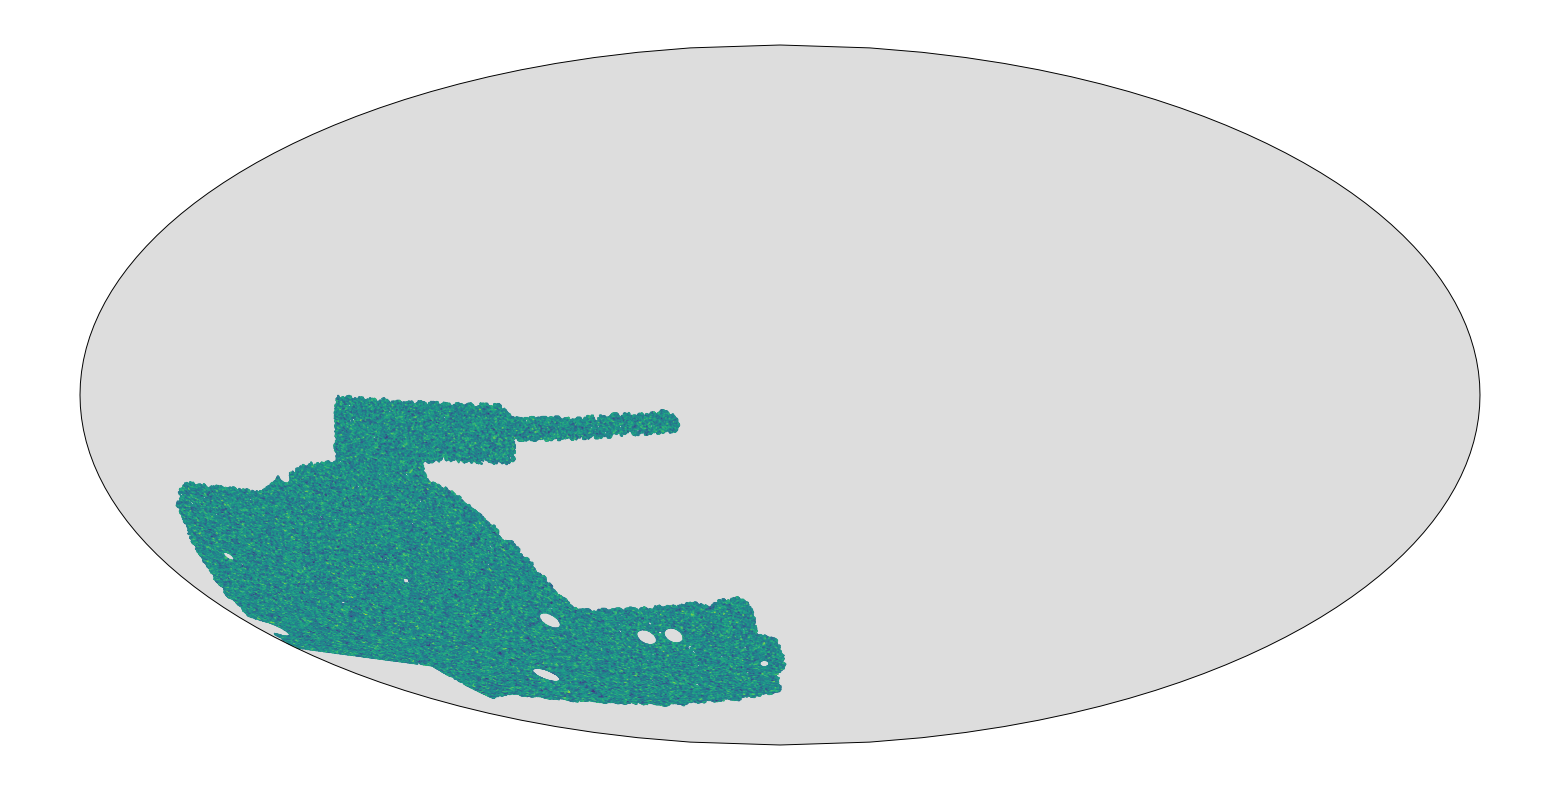

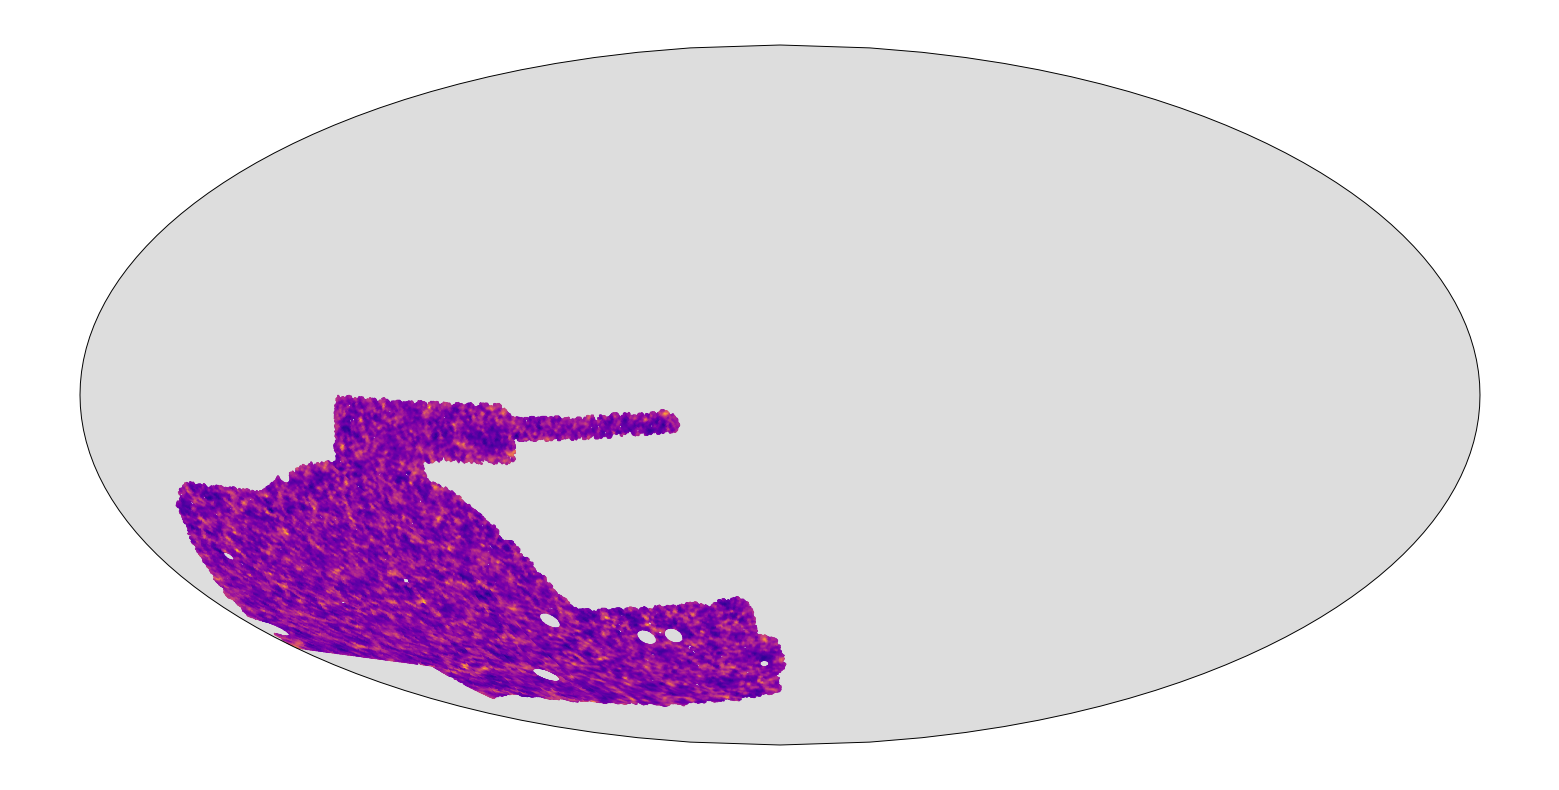

In [10]:
i_batch = 0

# lensing
i_tomo = 0

hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[grid_pipe.patch_pix] = data_vectors[i_batch,:,i_tomo]

temp = np.ma.masked_where(hp_map==hp.UNSEEN, hp_map)
moll = Map(projection.Mollweide())
moll.healpix(temp, cmap="viridis", nest=True, color_percentiles=[0,100])

moll.fig.set_size_inches(16, 8)
moll.fig.savefig("plots/lensing_mollview.png", bbox_inches="tight", dpi=300)

# clustering
i_tomo = 4

hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[grid_pipe.patch_pix] = data_vectors[i_batch,:,i_tomo]

temp = np.ma.masked_where(hp_map==hp.UNSEEN, hp_map)
moll = Map(projection.Mollweide())
moll.healpix(temp, cmap="plasma", nest=True, color_percentiles=[0,100])

moll.fig.set_size_inches(16, 8)
moll.fig.savefig("plots/clustering_mollview.png", bbox_inches="tight", dpi=300)


### gnomview

In [40]:
gnoms = []
for i in range(data_vectors.shape[-1]):
    hp_map = np.zeros(n_pix)
    hp_map[grid_pipe.patch_pix] = data_vectors[0,:,i]
    
    gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=1, xsize=600, ysize=600, return_projected_map=True, no_plot=True)
    gnom = np.ma.masked_where(gnom==0, gnom)

    gnoms.append(gnom)
    
lensing_gnoms = gnoms[:4]
clustering_gnoms = gnoms[4:]

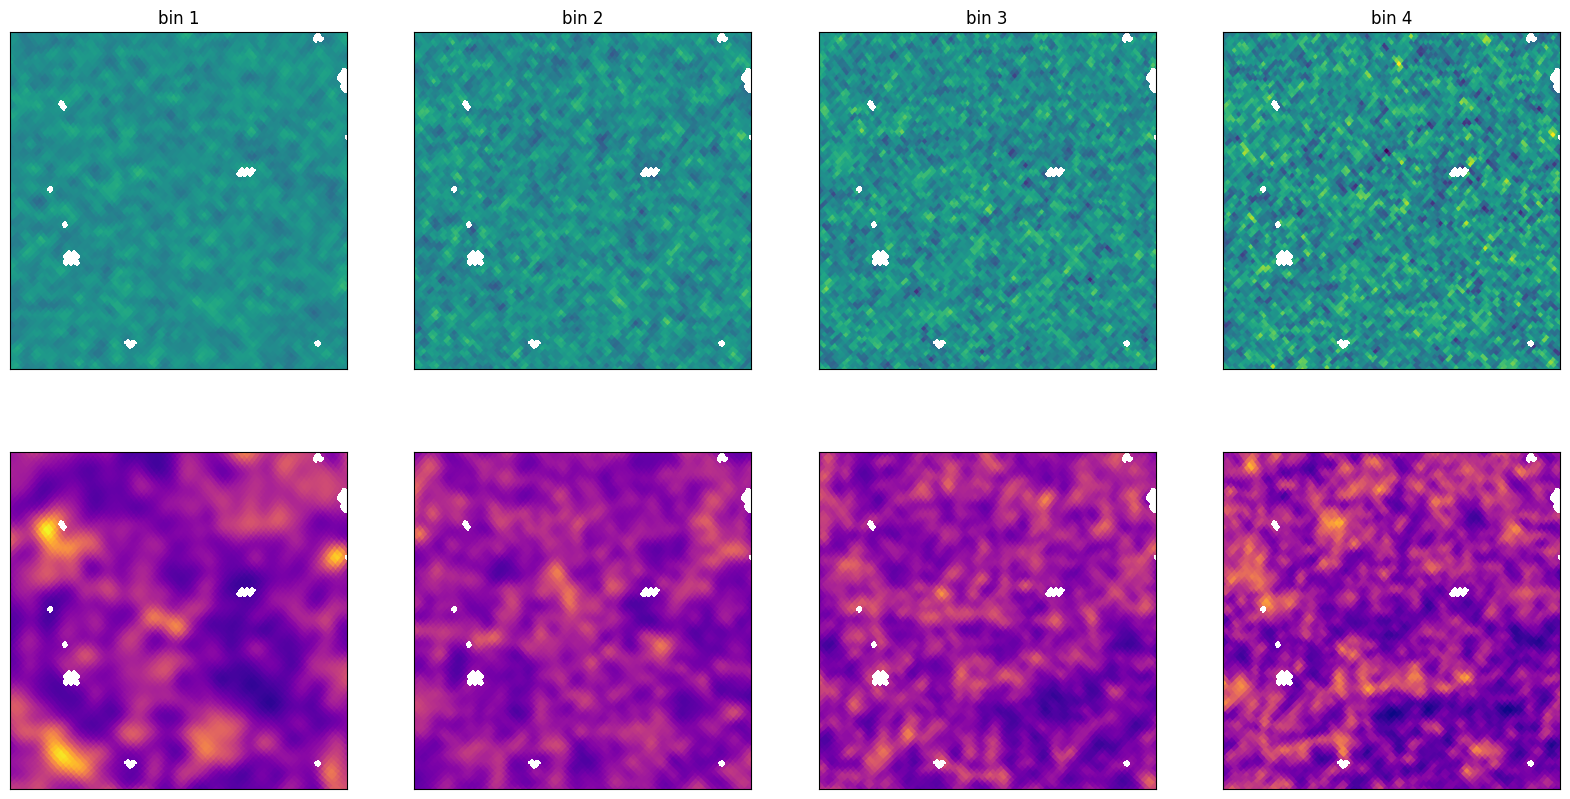

In [47]:
n_probes = 2
n_tomo = 4
assert n_probes * n_tomo == data_vectors.shape[-1]

probe_names = ["weak lensing", "galaxy clustering"]

fig, ax = plt.subplots(nrows=n_probes, ncols=n_tomo, figsize=(20, 10))

for i, probe_gnoms in enumerate([lensing_gnoms, clustering_gnoms]):
    if i == 0:
        cmap = "viridis"
    else:
        cmap = "plasma"
        
    vmin = np.nanmin(np.asarray(probe_gnoms))
    vmax = np.nanmax(np.asarray(probe_gnoms))
        
    for j in range(ax.shape[1]):
        ax[i,j].imshow(probe_gnoms[j], cmap=cmap, vmin=vmin, vmax=vmax)
        
        # cosmetics
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        if i == 0:
            ax[i,j].set(title=f"bin {j+1}")
            
        # if j == 0:
        #     ax[i,j].set(ylabel=probe_names[i])
            
fig.savefig("plots/gnomview.png", bbox_inches="tight", dpi=300, transparent=True)